# Building Data Genome Project 2.0
## Models evaluation

Biam! (pic.biam@gmail.com)

In [1]:
import pandas as pd
import numpy as np
import math

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns

from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error

In [2]:
path_pred = "..\\data\\predictions\\"

## Functions

In [3]:
def root_mean_squared_error(df, y_true, y_pred):
    mse = mean_squared_error(df[y_true], df[y_pred])
    rmse = math.sqrt(mse)
    return rmse

def root_mean_squared_log_error(df, y_true, y_pred):
    temp = df[df[y_pred] > 0]
    msle = mean_squared_log_error(temp[y_true], temp[y_pred])
    rmsle = math.sqrt(msle)
    return rmsle

def coefficient_of_variation_root_mean_squared_error(df, y_true, y_pred):
    mse = mean_squared_error(df[y_true], df[y_pred])
    rmse = math.sqrt(mse)
    cvrmse = rmse / np.mean(df[y_true]) * 100
    return cvrmse

def mean_bias_error(df, y_true, y_pred):
    dif = df[y_true] - df[y_pred]
    mbe = (np.sum(dif) / np.sum(df[y_true])) * 100
    return mbe

def r_squared(df, y_true, y_pred):
    r2 = r2_score(df[y_true], df[y_pred])
    return r2

def allMetrics(df, y_true, y_pred):
    # Calculate all
    metrics = {
        "RMSE": round(root_mean_squared_error(df,y_true, y_pred),4),
        "RMSLE": round(root_mean_squared_log_error(df, y_true, y_pred),4),
        "CVRMSE": round(coefficient_of_variation_root_mean_squared_error(df, y_true, y_pred),4),
        "MBE": round(mean_bias_error(df, y_true, y_pred),4),
        "R2": round(r_squared(df, y_true, y_pred),4),
    }
    return metrics

In [4]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Short-term prediction

### Winter season

In [5]:
st_winter = pd.read_csv(path_pred + "shortterm-winter_pred.csv", parse_dates=True, index_col='timestamp')
st_winter.dropna(inplace=True)
st_winter.reset_index(inplace=True)

In [6]:
st_winter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189512 entries, 0 to 189511
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      189512 non-null  datetime64[ns]
 1   building_id    189512 non-null  object        
 2   meter          189512 non-null  object        
 3   meter_reading  189512 non-null  float64       
 4   LGBM           189512 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 7.2+ MB


In [7]:
st_winter.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-02-01 00:00:00,Panther_lodging_Cora,chilledwater,136.0769,1464.273186
1,2017-02-01 01:00:00,Panther_lodging_Cora,chilledwater,123.7063,1458.233921
2,2017-02-01 02:00:00,Panther_lodging_Cora,chilledwater,111.3357,1045.975740
3,2017-02-01 03:00:00,Panther_lodging_Cora,chilledwater,86.5944,1045.975740
4,2017-02-01 04:00:00,Panther_lodging_Cora,chilledwater,86.5944,1045.975740


#### Plots

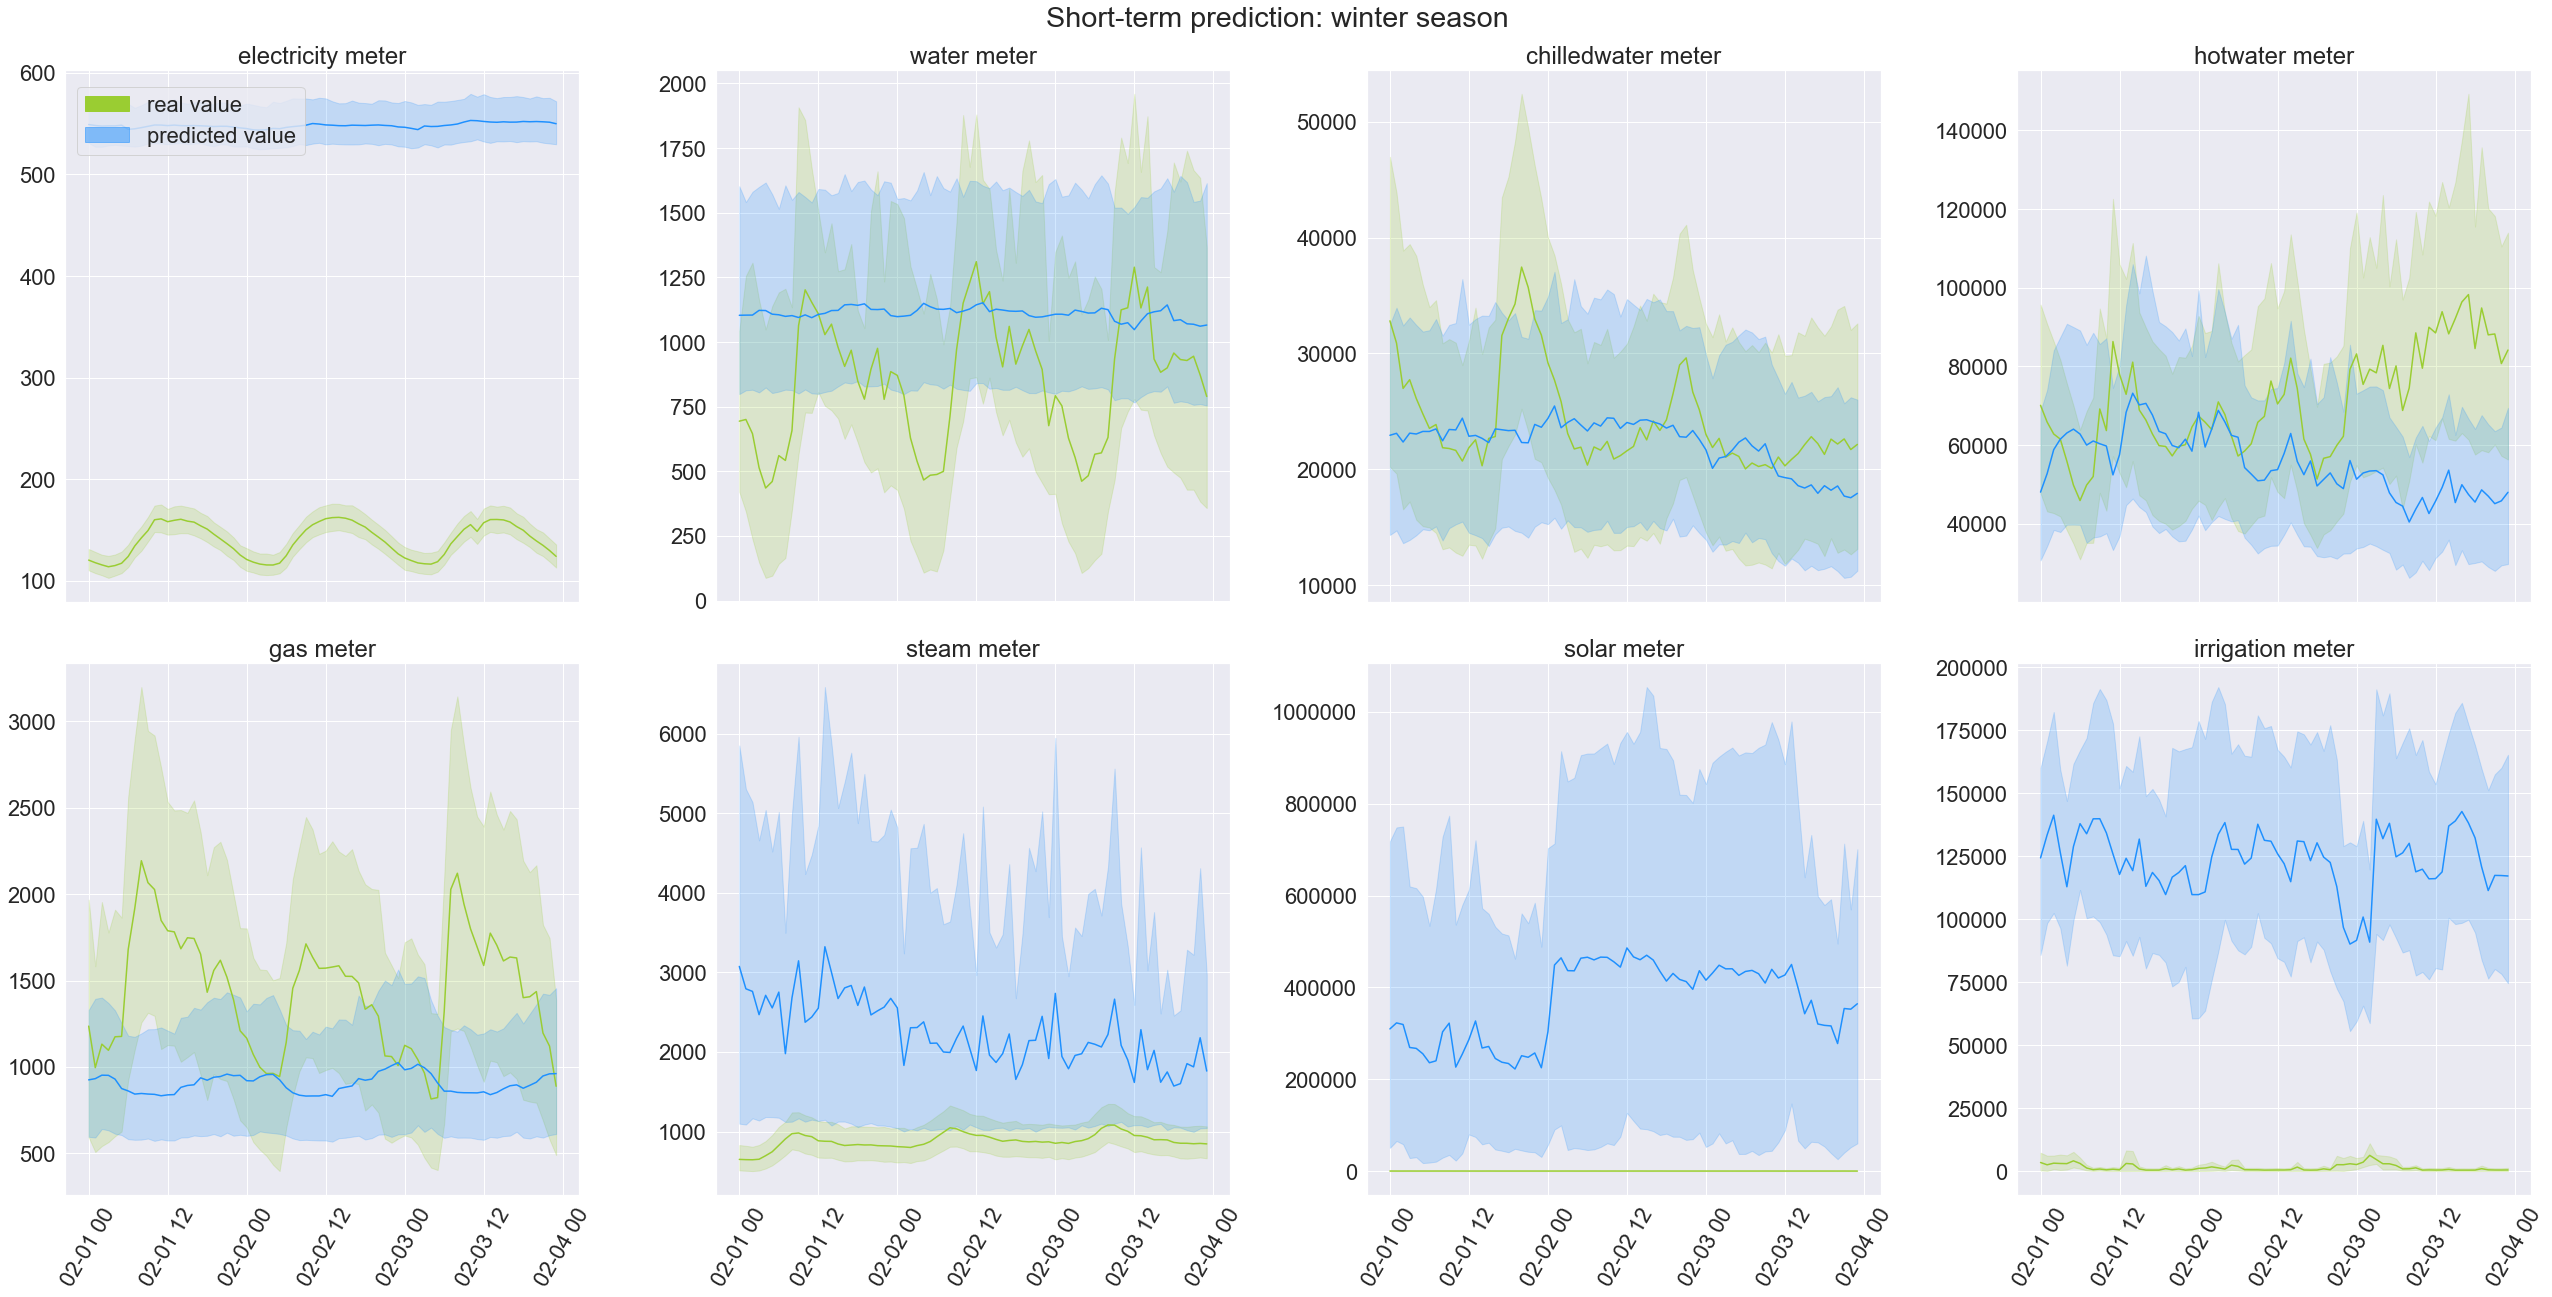

In [8]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4, sharex=True)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = st_winter[st_winter.meter==j]
    ax = axes[i]
    sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax=ax, color=color_real)
    sns.lineplot(data=temp, x="timestamp", y="LGBM", ax=ax, color = color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="", ylabel="")
    
    if i in [4,5,6,7]:        
        ax.xaxis_date()
        ax.tick_params("x", labelrotation=60)
    
    else:      
        continue
        
# Customizes legend and title
green_patch = mpatches.Patch(color=color_real, label='real value')
blue_patch = mpatches.Patch(color=color_pred, label='predicted value', alpha=0.5)
f.legend(handles=[green_patch, blue_patch], ncol=1, loc= [0.03, 0.88])
f.suptitle("Short-term prediction: winter season", x = 0.5, y = 1.01)
f.tight_layout()

In [9]:
f.savefig("..\\figures\\pred_shortterm-winter1.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_shortterm-winter1.png", dpi=72, bbox_inches='tight')

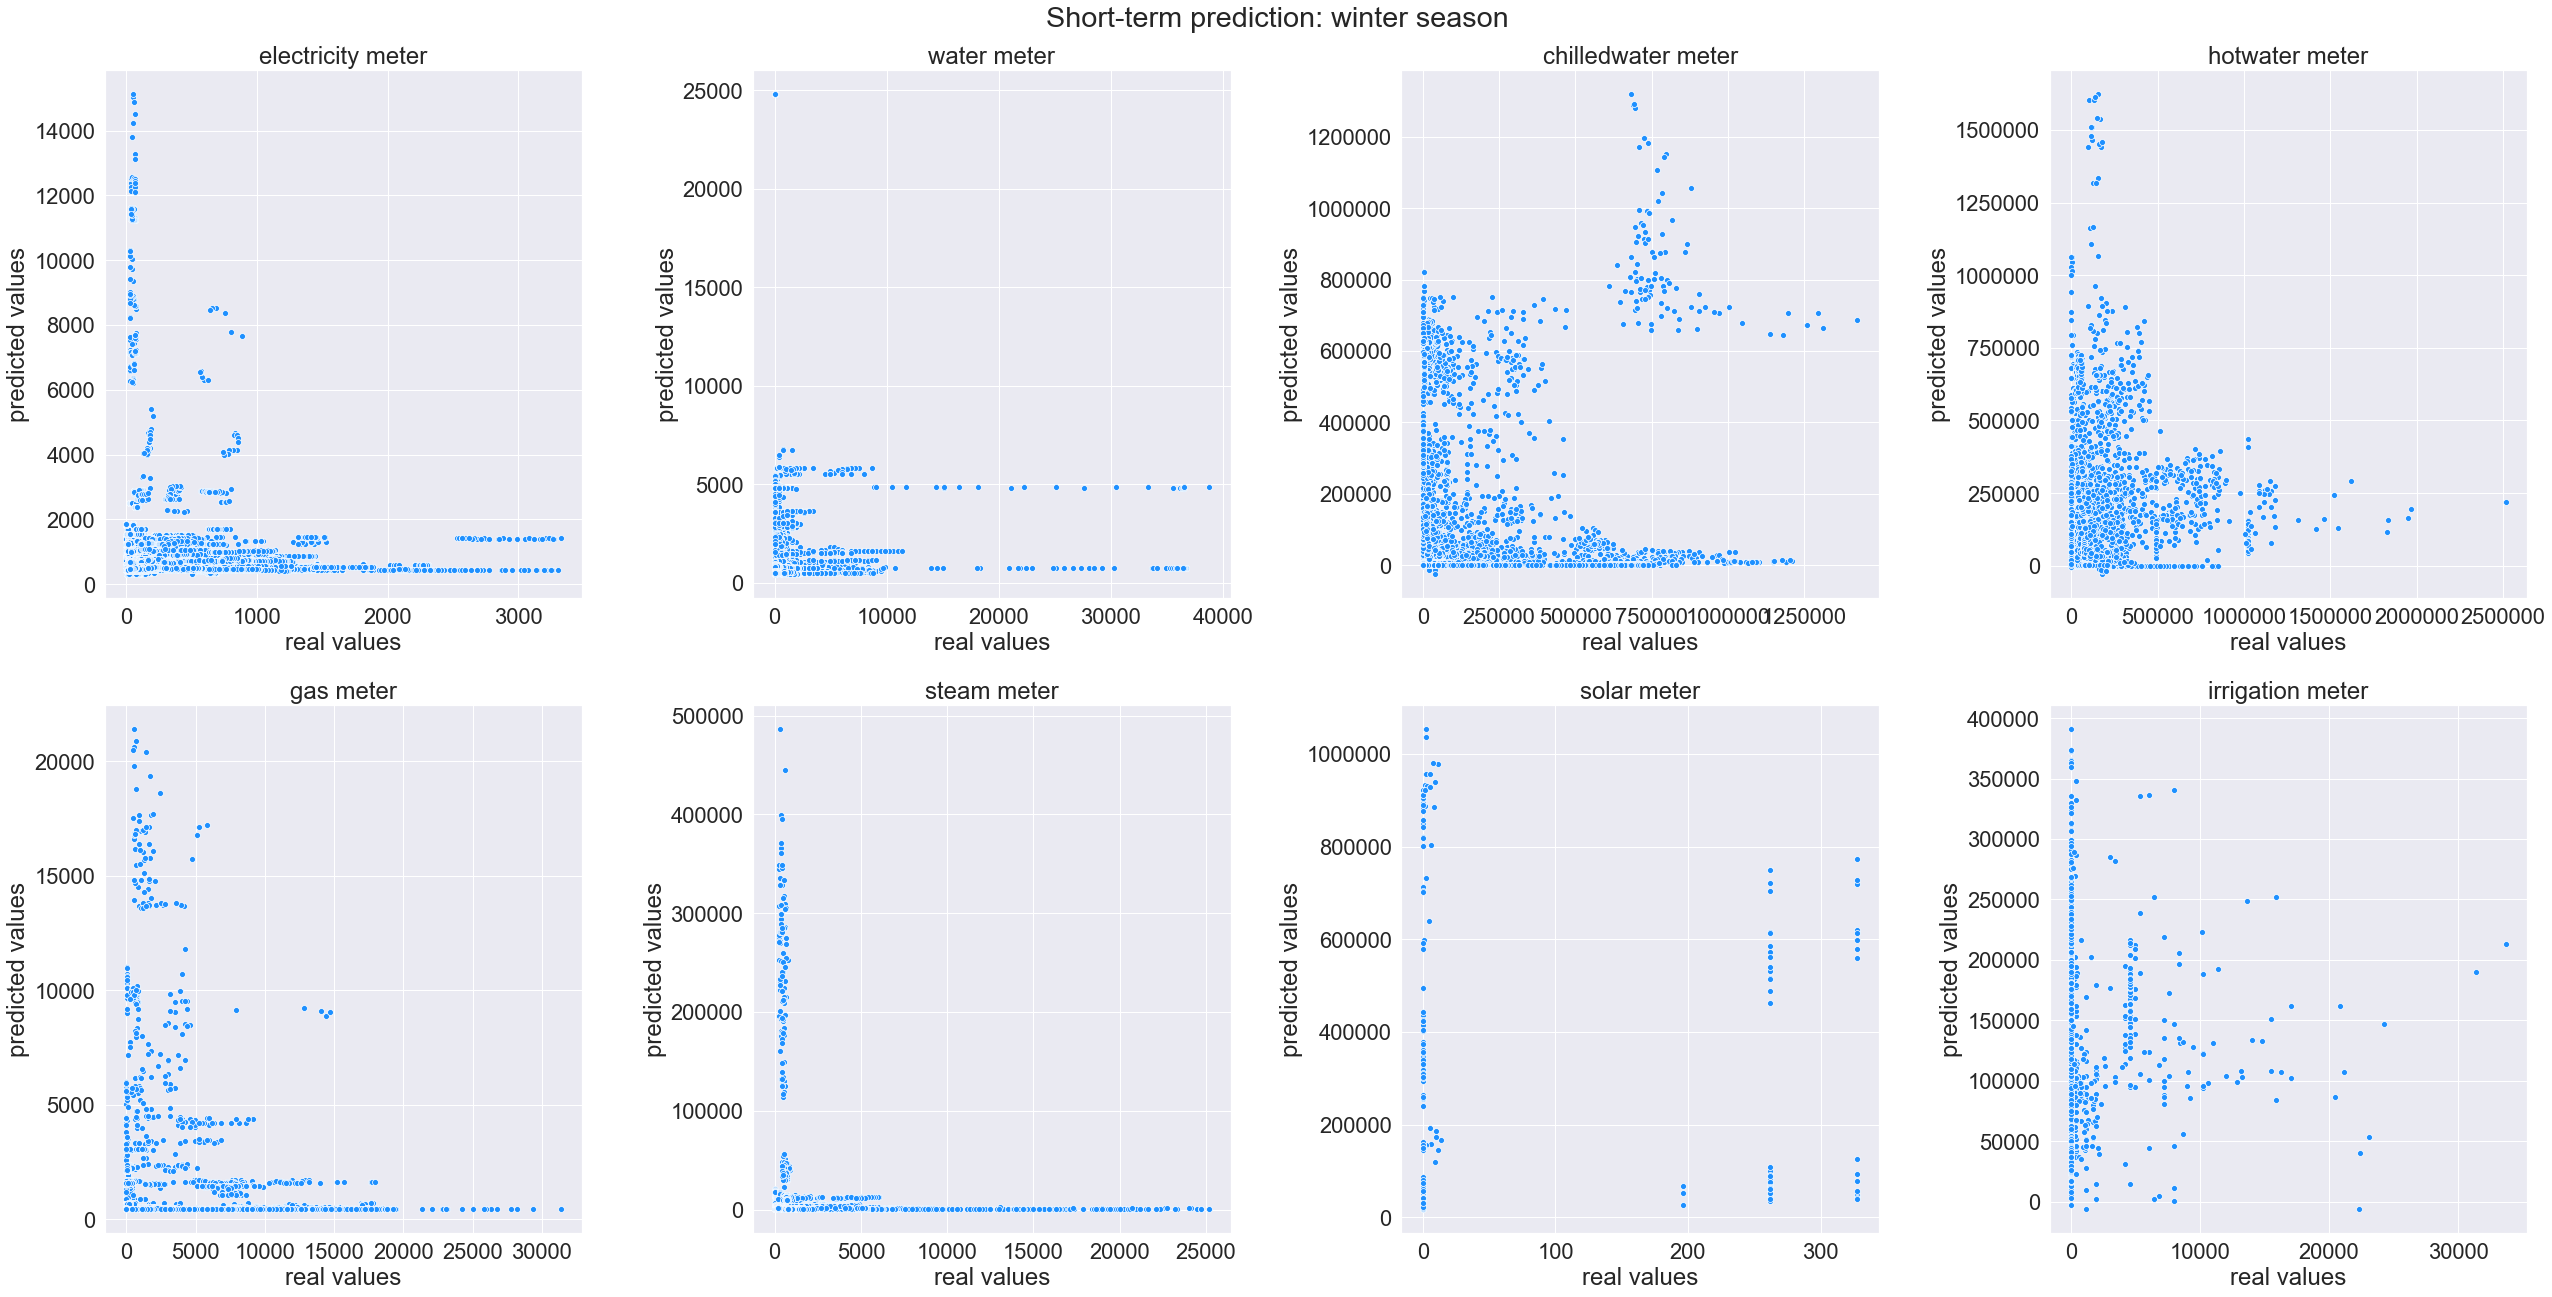

In [10]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = st_winter[st_winter.meter==j]
    ax = axes[i]
    sns.scatterplot(data=temp, x="meter_reading", y="LGBM", ax=ax, color=color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="real values", ylabel="predicted values")

f.suptitle("Short-term prediction: winter season", x = 0.5, y = 1.01)
f.tight_layout()

In [11]:
f.savefig("..\\figures\\pred_shortterm-winter2.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_shortterm-winter2.png", dpi=72, bbox_inches='tight')

### Summer season

In [12]:
st_summer = pd.read_csv(path_pred + "shortterm-summer_pred.csv", parse_dates=True, index_col='timestamp')
st_summer.dropna(inplace=True)
st_summer.reset_index(inplace=True)

In [13]:
st_summer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188233 entries, 0 to 188232
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   timestamp      188233 non-null  datetime64[ns]
 1   building_id    188233 non-null  object        
 2   meter          188233 non-null  object        
 3   meter_reading  188233 non-null  float64       
 4   LGBM           188233 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 7.2+ MB


In [14]:
st_summer.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-08-01 00:00:00,Panther_office_Clementine,chilledwater,247.4126,4405.712230
1,2017-08-01 01:00:00,Panther_office_Clementine,chilledwater,247.4126,4405.712230
2,2017-08-01 02:00:00,Panther_office_Clementine,chilledwater,235.0420,4394.333787
3,2017-08-01 03:00:00,Panther_office_Clementine,chilledwater,247.4126,4394.333787
4,2017-08-01 04:00:00,Panther_office_Clementine,chilledwater,247.4126,4373.447535


#### Plots

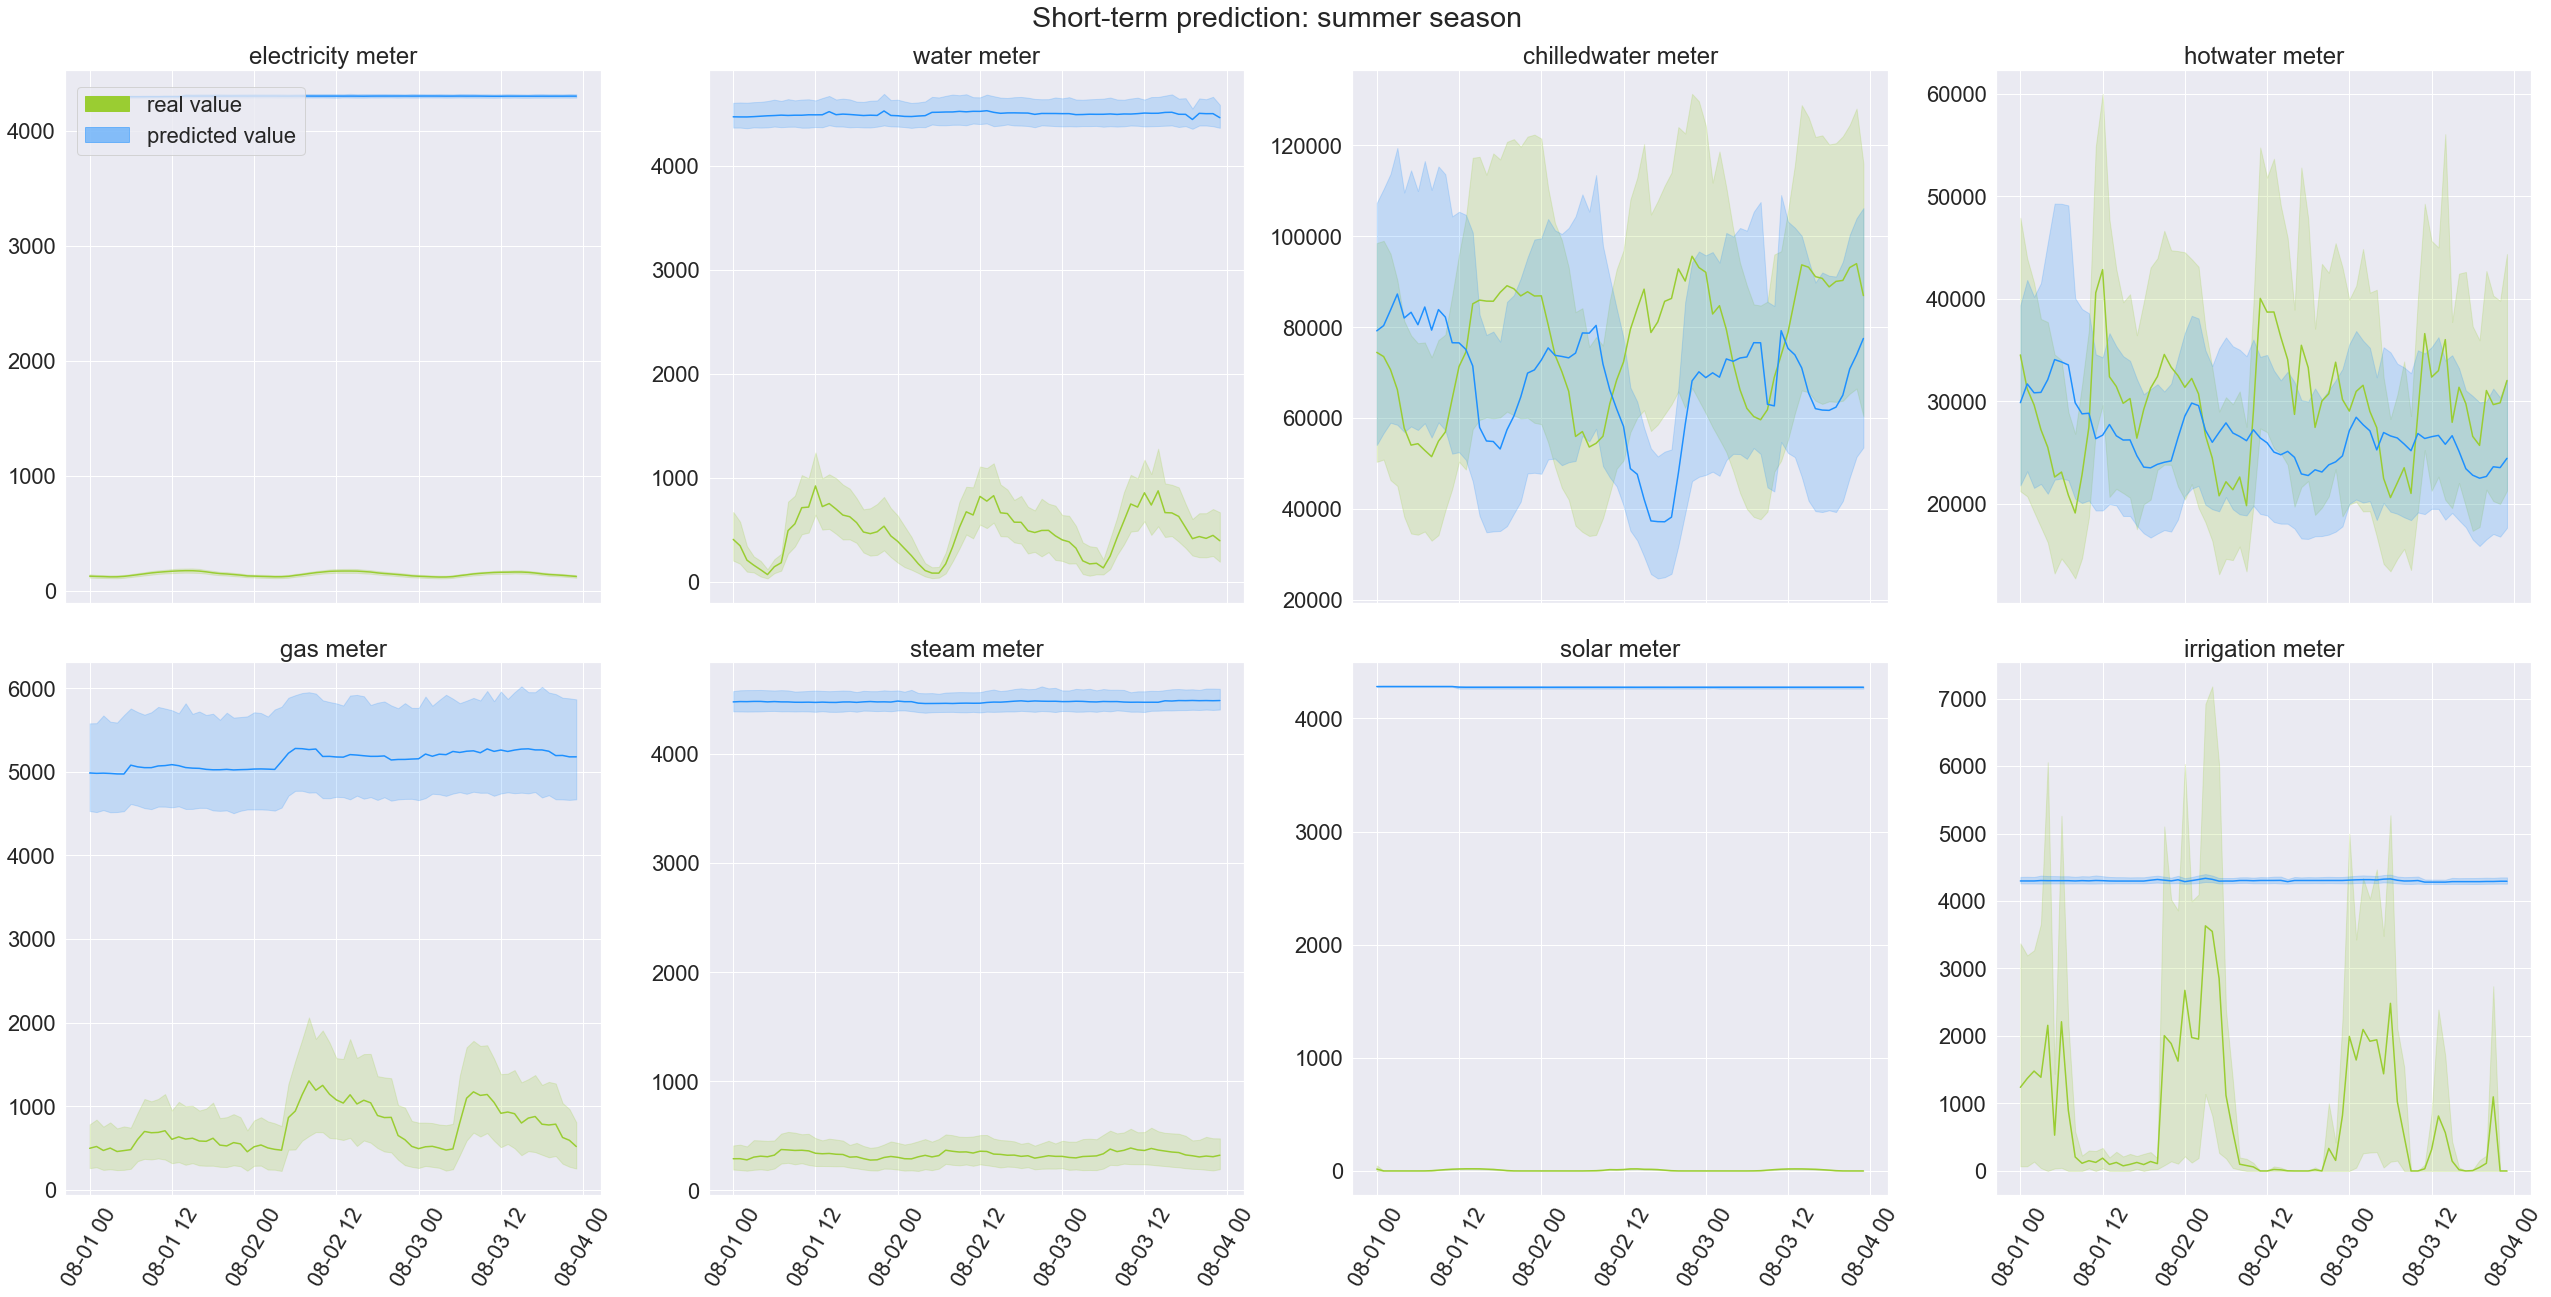

In [15]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4, sharex=True)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = st_summer[st_summer.meter==j]
    ax = axes[i]
    sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax=ax, color=color_real)
    sns.lineplot(data=temp, x="timestamp", y="LGBM", ax=ax, color = color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="", ylabel="")
    
    if i in [4,5,6,7]:        
        ax.xaxis_date()
        ax.tick_params("x", labelrotation=60)
    
    else:      
        continue
        
# Customizes legend and title
green_patch = mpatches.Patch(color=color_real, label='real value')
blue_patch = mpatches.Patch(color=color_pred, label='predicted value', alpha=0.5)
f.legend(handles=[green_patch, blue_patch], ncol=1, loc= [0.03, 0.88])
f.suptitle("Short-term prediction: summer season", x = 0.5, y = 1.01)
f.tight_layout()

In [16]:
f.savefig("..\\figures\\pred_shortterm-summer1.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_shortterm-summer1.png", dpi=72, bbox_inches='tight')

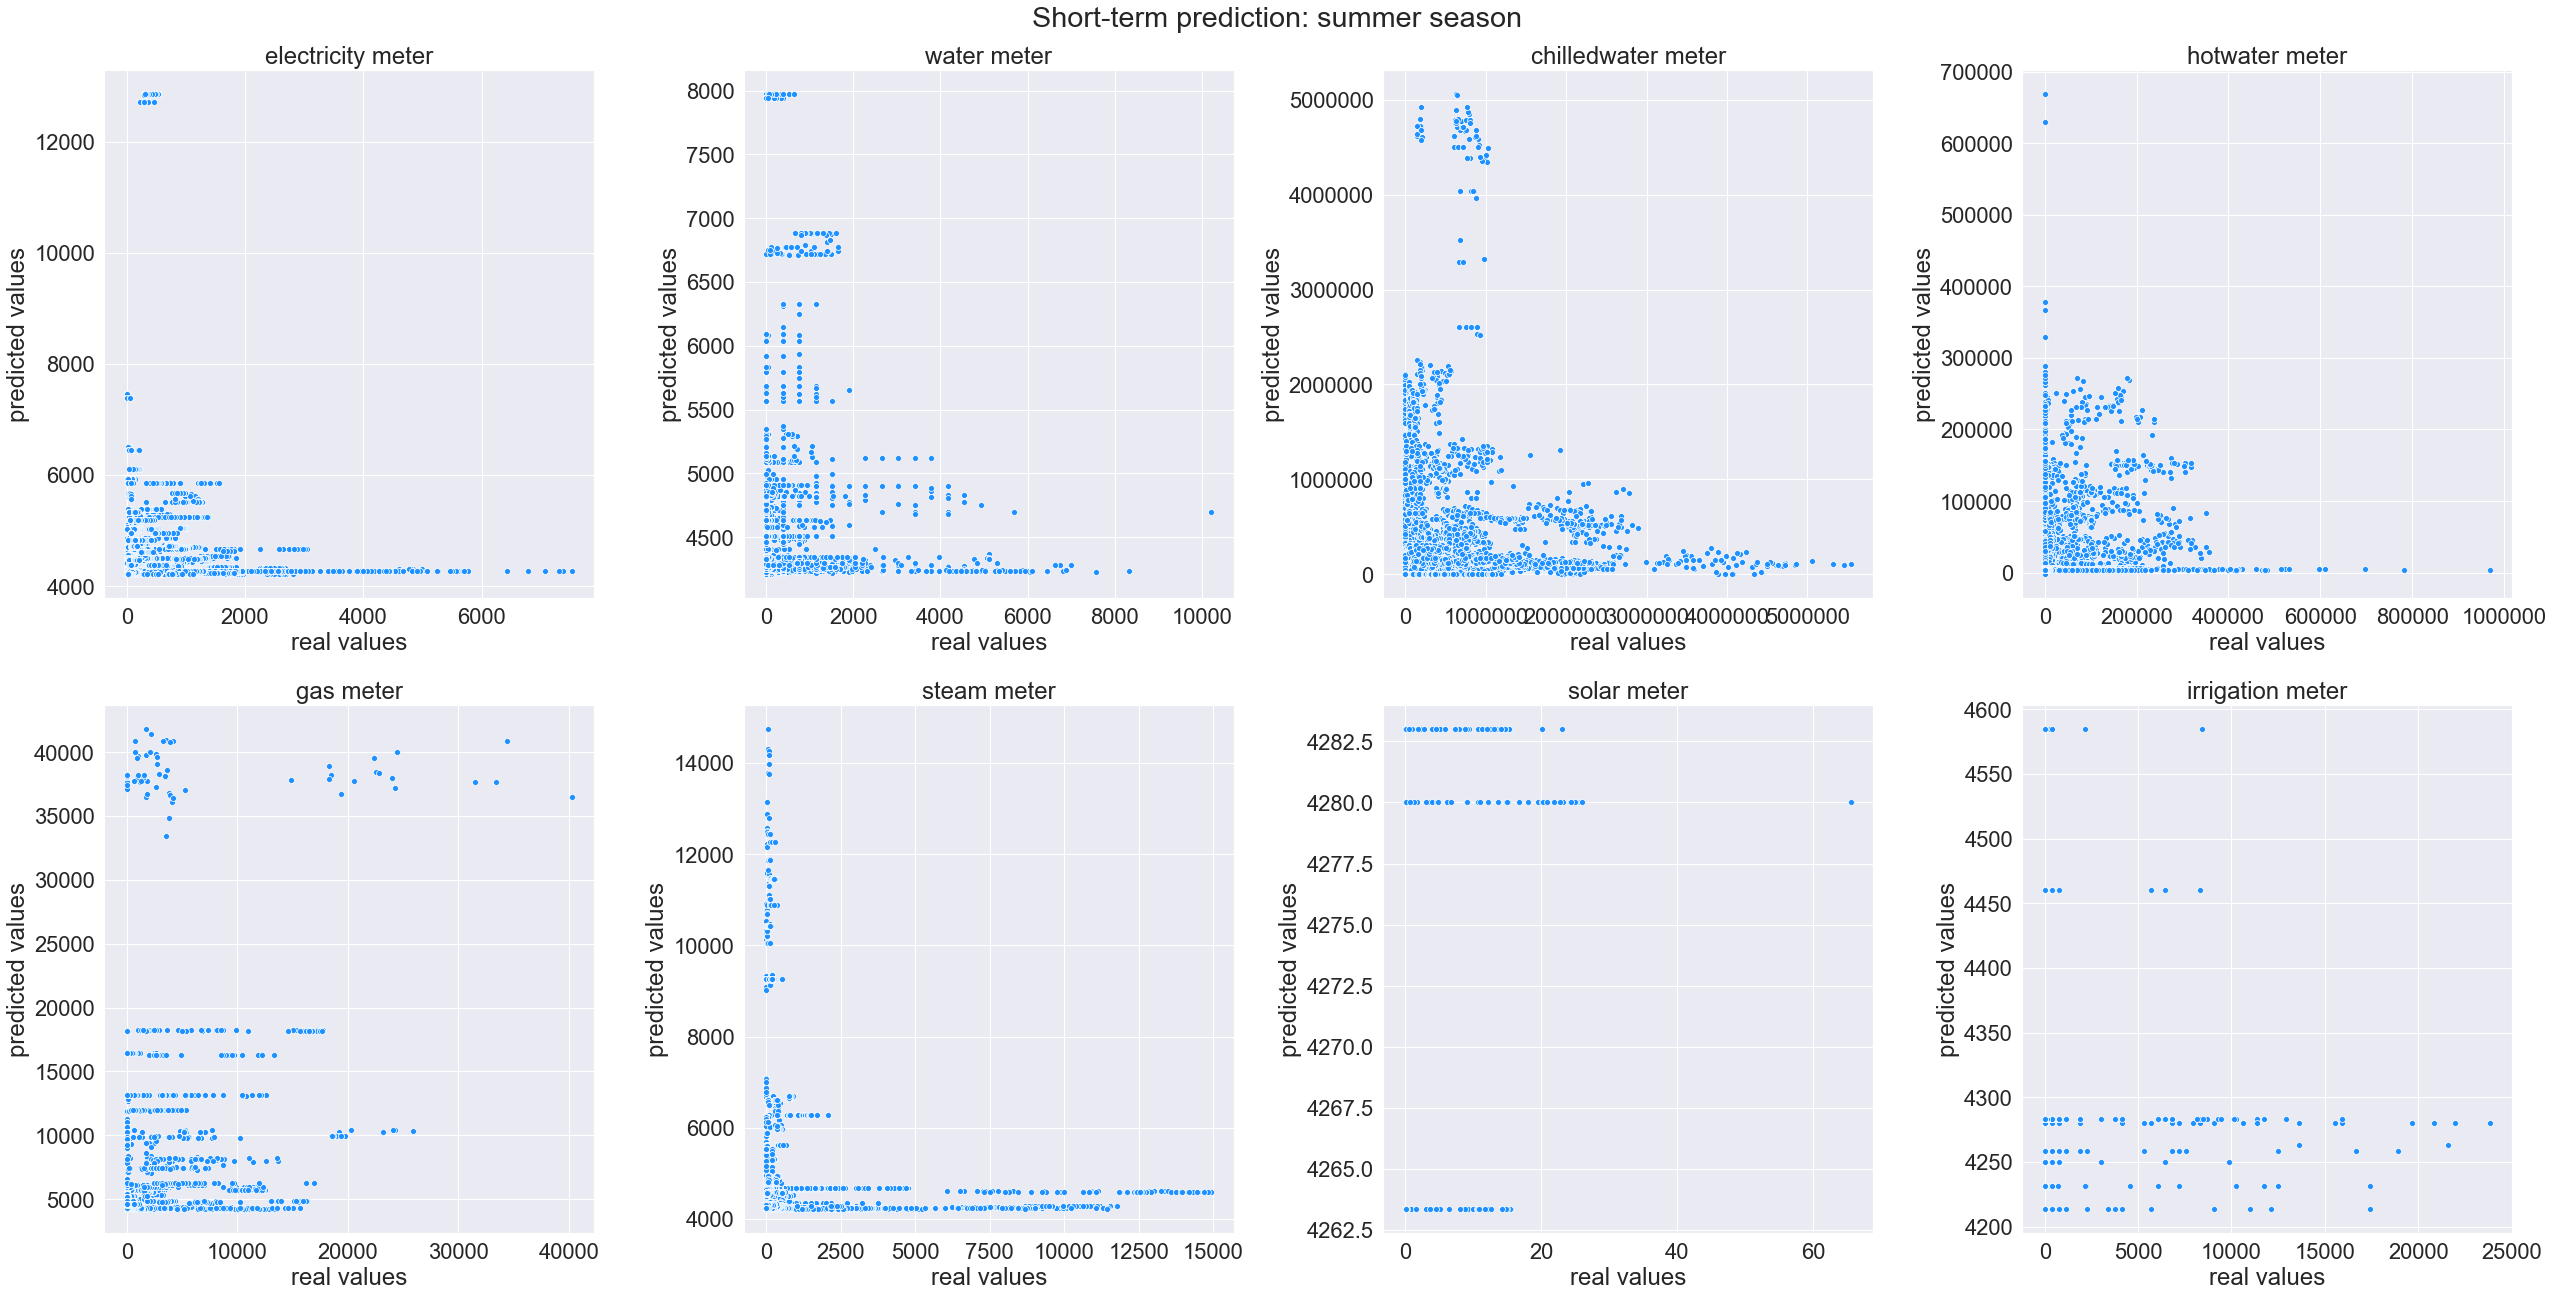

In [17]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = st_summer[st_summer.meter==j]
    ax = axes[i]
    sns.scatterplot(data=temp, x="meter_reading", y="LGBM", ax=ax, color=color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="real values", ylabel="predicted values")

f.suptitle("Short-term prediction: summer season", x = 0.5, y = 1.01)
f.tight_layout()

In [18]:
f.savefig("..\\figures\\pred_shortterm-summer2.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_shortterm-summer2.png", dpi=72, bbox_inches='tight')

## Long-term prediction

In [19]:
lt = pd.read_csv(path_pred + "longterm_pred.csv", parse_dates=True, index_col='timestamp')
lt.dropna(inplace=True)
lt.reset_index(inplace=True)

In [20]:
lt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22455386 entries, 0 to 22455385
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   building_id    object        
 2   meter          object        
 3   meter_reading  float64       
 4   LGBM           float64       
dtypes: datetime64[ns](1), float64(2), object(2)
memory usage: 856.6+ MB


In [21]:
lt.head()

,timestamp,building_id,meter,meter_reading,LGBM
0,2017-04-17 14:00:00,Panther_office_Clementine,chilledwater,0.0000,4587.771116
1,2017-04-17 15:00:00,Panther_office_Clementine,chilledwater,86.5944,4587.771116
2,2017-04-17 16:00:00,Panther_office_Clementine,chilledwater,309.2658,4587.771116
3,2017-04-17 17:00:00,Panther_office_Clementine,chilledwater,284.5245,4587.771116
4,2017-04-17 18:00:00,Panther_office_Clementine,chilledwater,247.4126,4587.771116


#### Plots

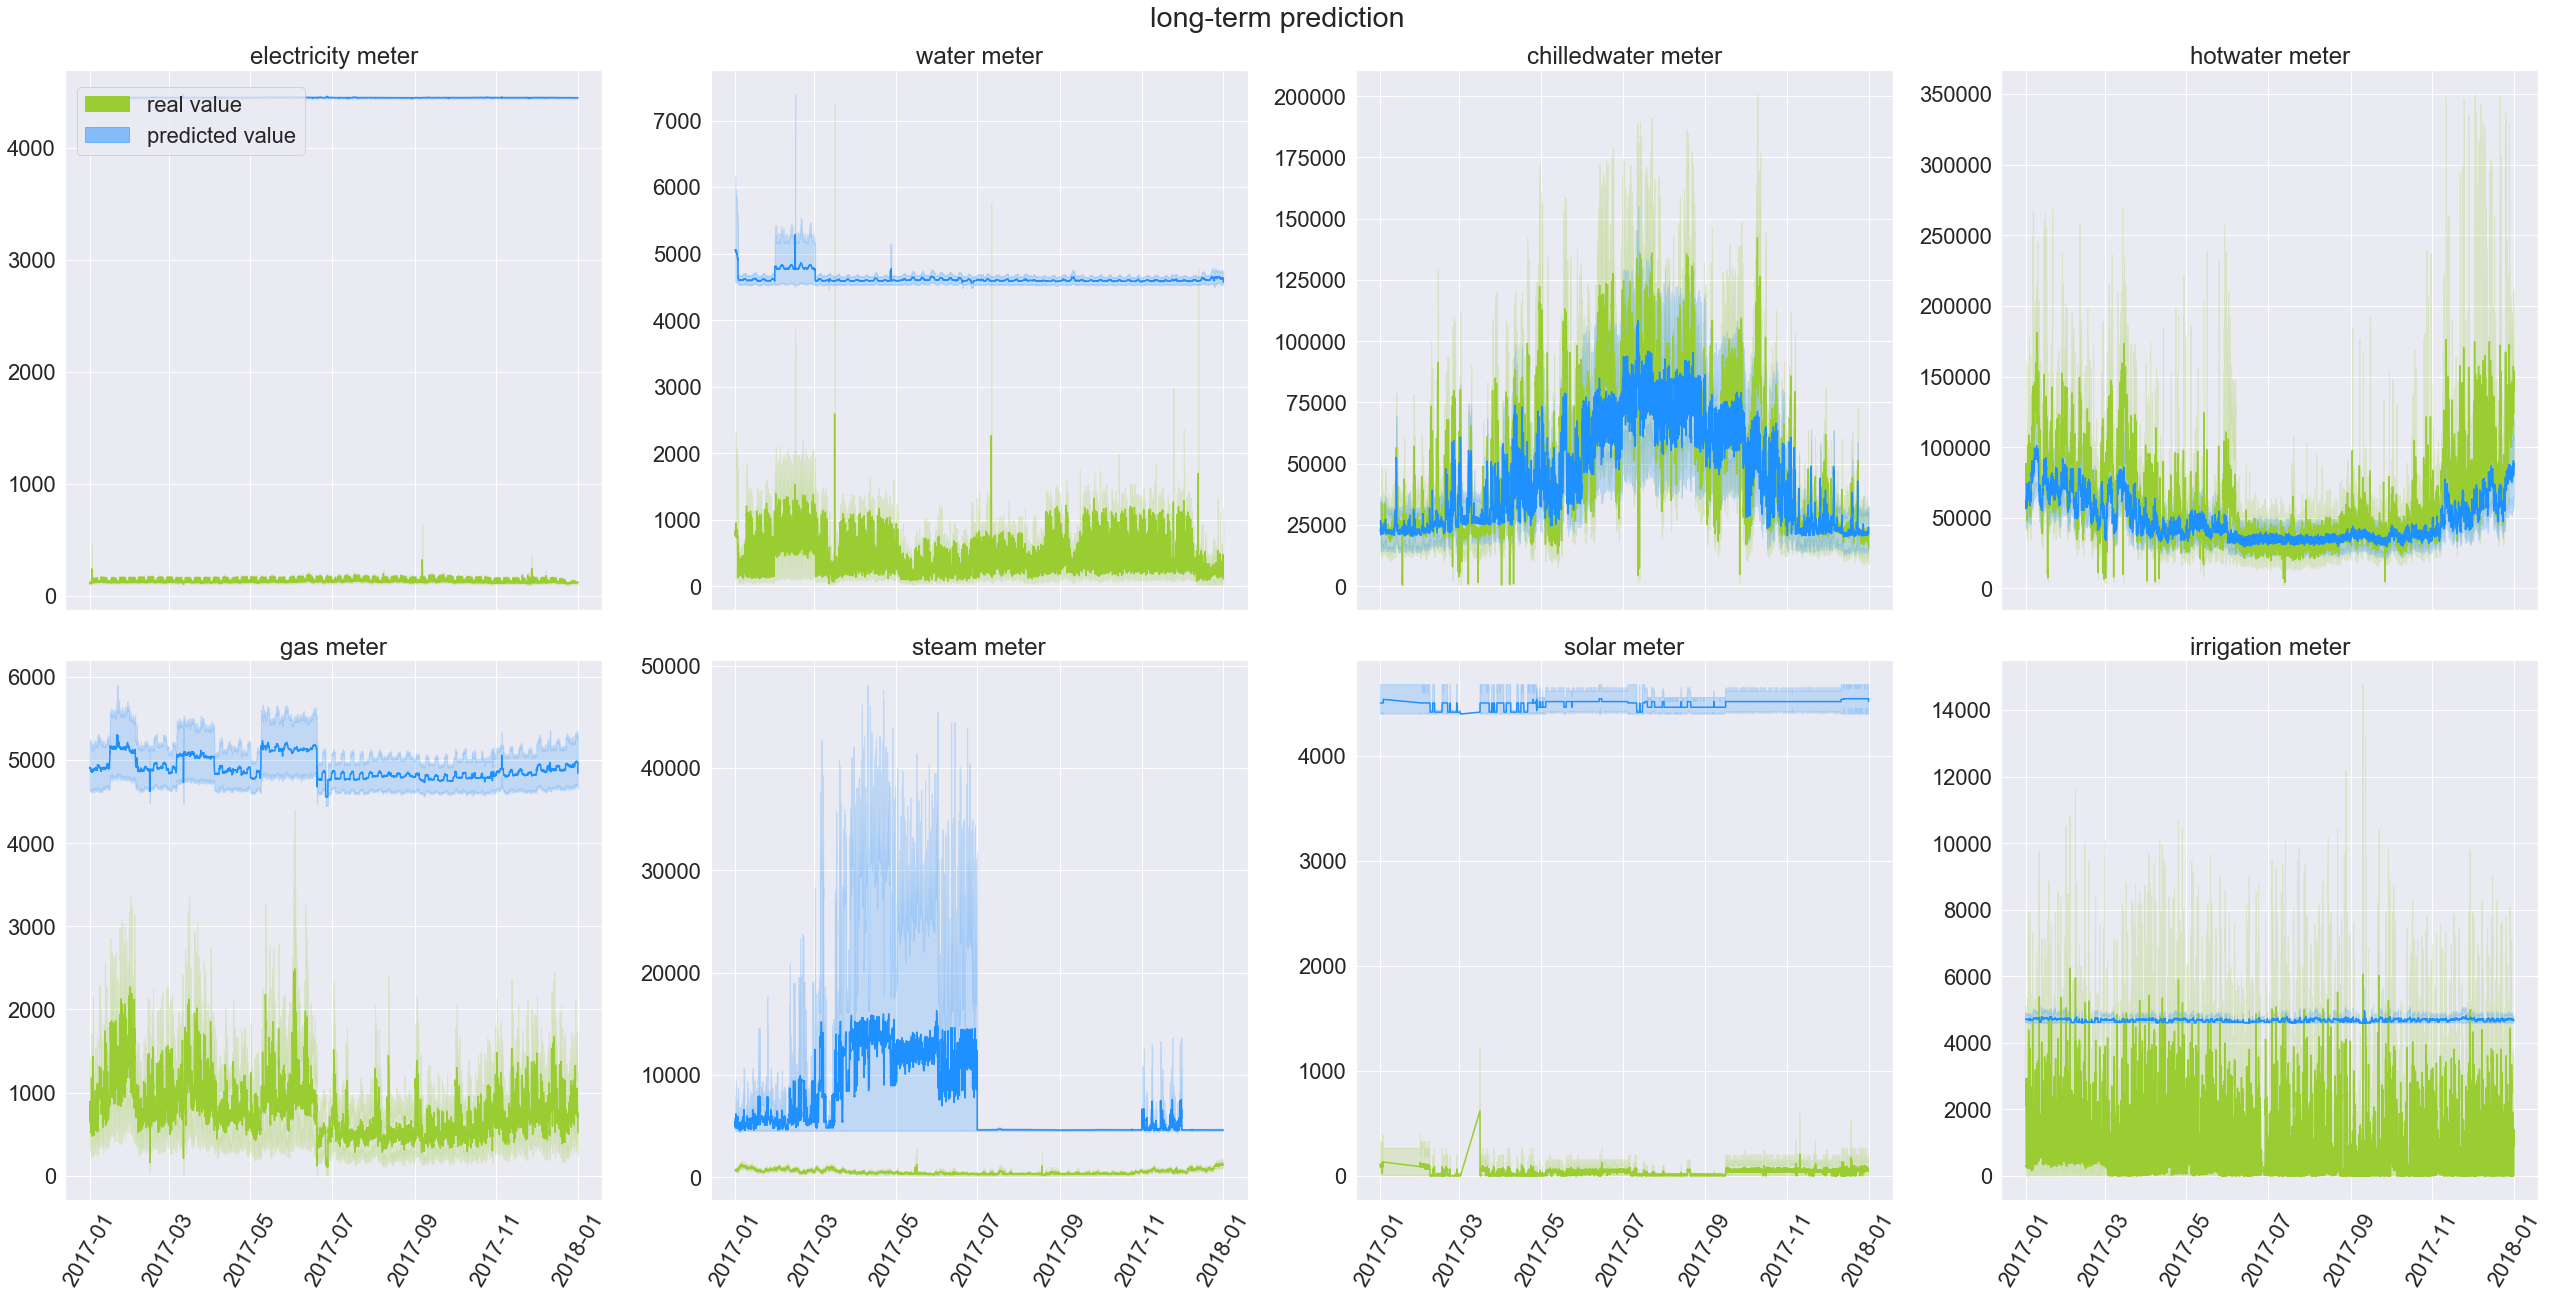

In [22]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4, sharex=True)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = lt[lt.meter==j]
    ax = axes[i]
    sns.lineplot(data=temp, x="timestamp", y="meter_reading", ax=ax, color=color_real)
    sns.lineplot(data=temp, x="timestamp", y="LGBM", ax=ax, color = color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="", ylabel="")
    
    if i in [4,5,6,7]:        
        ax.xaxis_date()
        ax.tick_params("x", labelrotation=60)
    
    else:      
        continue
        
# Customizes legend and title
green_patch = mpatches.Patch(color=color_real, label='real value')
blue_patch = mpatches.Patch(color=color_pred, label='predicted value', alpha=0.5)
f.legend(handles=[green_patch, blue_patch], ncol=1, loc= [0.03, 0.88])
f.suptitle("long-term prediction", x = 0.5, y = 1.01)
f.tight_layout()

In [23]:
f.savefig("..\\figures\\pred_longterm1.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_longterm1.png", dpi=72, bbox_inches='tight')

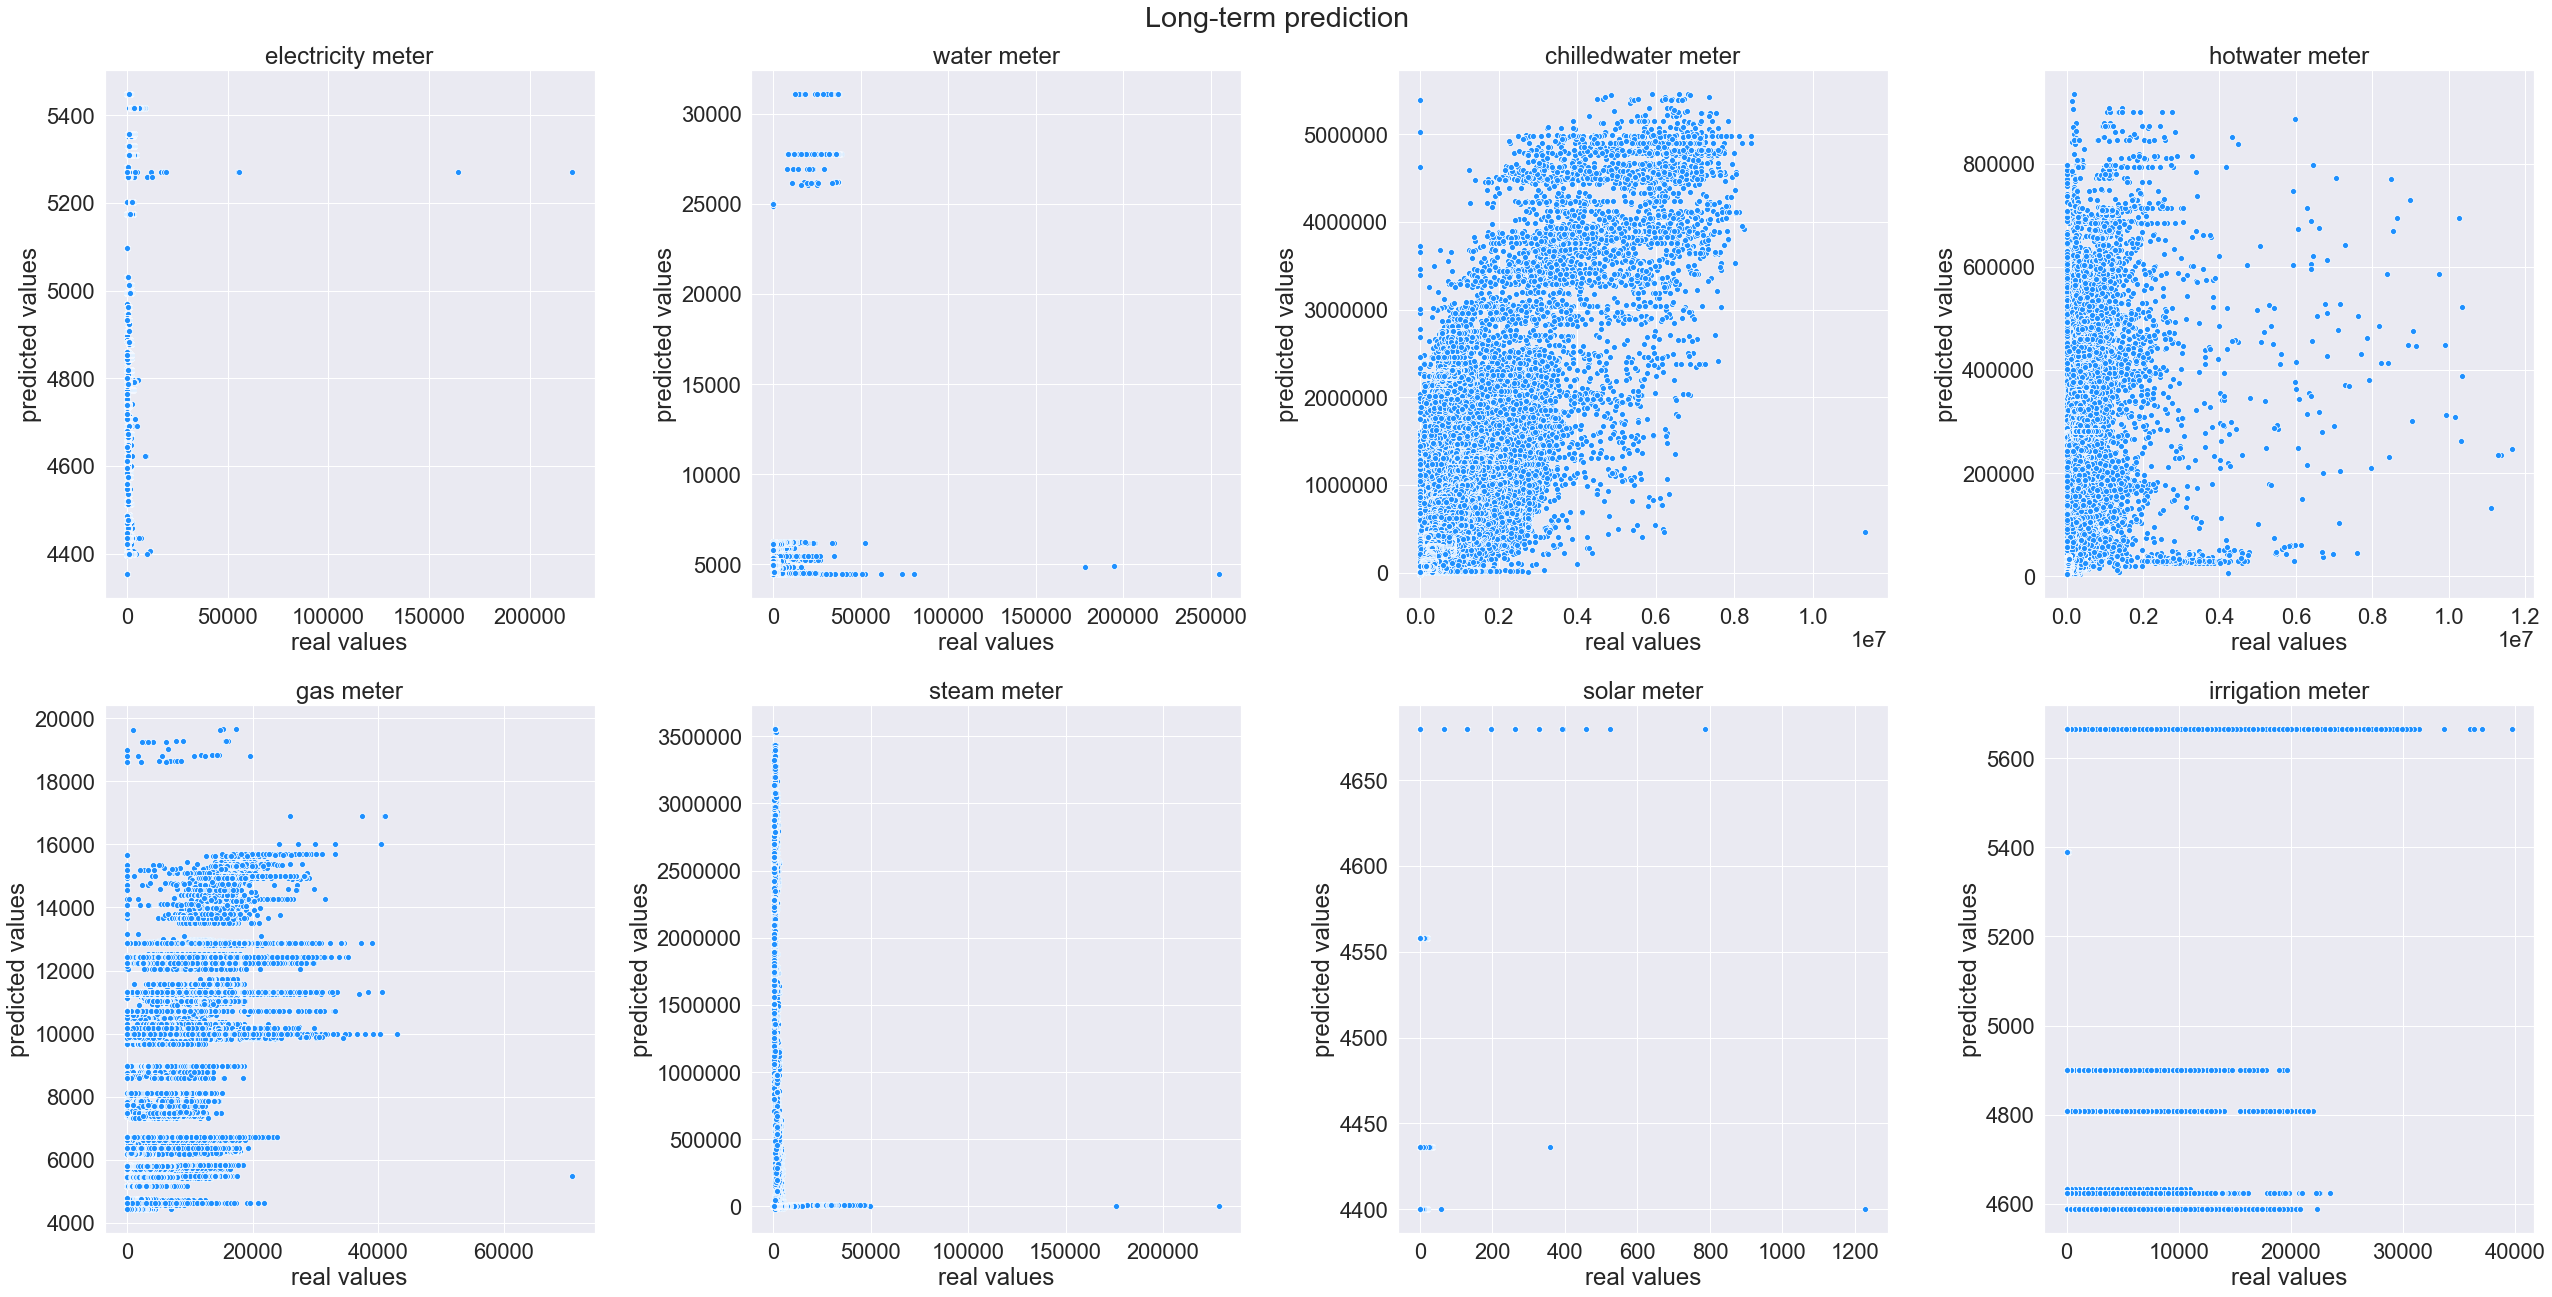

In [24]:
sns.set(rc={'figure.figsize':(36,18)})
sns.set(font_scale = 2)
f, axes = plt.subplots(2, 4)
axes = axes.flatten()

color_real = "yellowgreen"
color_pred = "dodgerblue"

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    temp = lt[lt.meter==j]
    ax = axes[i]
    sns.scatterplot(data=temp, x="meter_reading", y="LGBM", ax=ax, color=color_pred)
    ax.title.set_text(j + " meter")
    ax.set(xlabel="real values", ylabel="predicted values")

f.suptitle("Long-term prediction", x = 0.5, y = 1.01)
f.tight_layout()

In [25]:
f.savefig("..\\figures\\pred_longterm2.pdf", bbox_inches='tight')
f.savefig("..\\figures\\pred_longterm2.png", dpi=72, bbox_inches='tight')

## Metrics

In [26]:
dfs = []

metrics_stw = allMetrics(st_winter, "meter_reading", "LGBM")
metrics_sts = allMetrics(st_summer, "meter_reading", "LGBM")
metrics_lt = allMetrics(lt, "meter_reading", "LGBM")
# A dataframe with all the metrics
metrics_meter = pd.DataFrame({"meter":"all","Short-term winter": metrics_stw, "Short-term summer": metrics_sts, "Long-term": metrics_lt})
# appends to list
dfs.append(metrics_meter)
    
metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i in metername:
    # All metrics for each model
    metrics_stw = allMetrics(st_winter[st_winter.meter == i], "meter_reading", "LGBM")
    metrics_sts = allMetrics(st_summer[st_summer.meter == i], "meter_reading", "LGBM")
    metrics_lt = allMetrics(lt[lt.meter == i], "meter_reading", "LGBM")
    # A dataframe with all the metrics
    metrics_meter = pd.DataFrame({"meter":i,"Short-term winter": metrics_stw, "Short-term summer": metrics_sts, "Long-term": metrics_lt})
    # appends to list
    dfs.append(metrics_meter)
    
complete_data = pd.concat(dfs, axis=0, ignore_index=False)

In [27]:
complete_data

,meter,Short-term winter,Short-term summer,Long-term
RMSE,all,6.826993e+04,164364.4351,65460.3931
RMSLE,all,3.369200e+00,4.7604,4.7370
CVRMSE,all,8.329655e+02,988.8850,528.2303
MBE,all,-2.573100e+00,-8.1802,-16.5143
R2,all,-2.983000e-01,-0.3541,0.6596
RMSE,electricity,6.286275e+02,4169.0895,4316.0369
RMSLE,electricity,3.052200e+00,4.8035,4.8547
CVRMSE,electricity,4.488936e+02,2838.8222,3146.8697
MBE,electricity,-2.915358e+02,-2827.0699,-3143.1904
R2,electricity,-6.148900e+00,-223.3112,-273.9723


In [28]:
complete_data.to_csv(path_pred + "metrics.csv", index=False)